In [ ]:
from __future__ import print_function
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn .functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
batch_size = 256
num_classes = 10
epochs= 50
learning_rate = 0.001
encoding_dim = 32

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_set, batch_size=batch_size, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_set, batch_size=batch_size, shuffle=False)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
AE = Autoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(AE.parameters(), lr=learning_rate)

In [ ]:
from torch.cuda import device_count
list_loss_train = []
list_accuracy_train = []
list_loss_test = []
list_accuracy_test = []
seuil = 0.5

for epoch in range(epochs):
    AE.train()
    sous_list_loss_train = []
    sous_valeur_accuracy_train = 0
    for data in mnist_train_loader:
        img, _ = data
        optimizer.zero_grad()
        img = img.to(device)
        output = AE(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()

        sous_list_loss_train.append(loss.item())
        sous_valeur_accuracy_train += ((output > seuil) == (img > seuil)).sum().item()

    total_pixels = img.view(img.size(0), -1).size(1)
    list_accuracy_train.append(sous_valeur_accuracy_train / (len(mnist_train_set) * total_pixels))
    list_loss_train.append(np.mean(sous_list_loss_train))

    AE.eval()
    with torch.no_grad():
        sous_list_loss_test = []
        sous_valeur_accuracy_test = 0
        for data in mnist_test_loader:
            img, _ = data
            img = img.to(device)
            output = AE(img)
            loss = criterion(output, img)
            sous_list_loss_test.append(loss.item())
            sous_valeur_accuracy_test += ((output > seuil) == (img > seuil)).sum().item()

        total_pixels = img.view(img.size(0), -1).size(1)
        list_accuracy_test.append(sous_valeur_accuracy_test / (len(mnist_test_set) * total_pixels))
        list_loss_test.append(np.mean(sous_list_loss_test))

    img = img.cpu().data.numpy()
    output = output.cpu().data.numpy()
    print('epoch [{}/{}], loss train:{:.4f}, loss test:{:.4f}, accuracy train:{:.4f}, accuracy test:{:.4f}'.format(epoch + 1, epochs, list_loss_train[-1], list_loss_test[-1], list_accuracy_train[-1], list_accuracy_test[-1]))

epoch [1/5], loss train:0.7829, loss test:0.5547, accuracy train:0.8882, accuracy test:0.9671
epoch [2/5], loss train:0.5162, loss test:0.5055, accuracy train:0.9760, accuracy test:0.9817
epoch [3/5], loss train:0.4896, loss test:0.4918, accuracy train:0.9839, accuracy test:0.9861
epoch [4/5], loss train:0.4805, loss test:0.4859, accuracy train:0.9869, accuracy test:0.9883
epoch [5/5], loss train:0.4760, loss test:0.4827, accuracy train:0.9887, accuracy test:0.9897


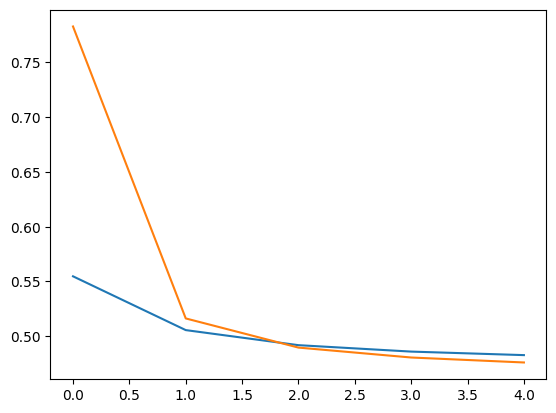

In [ ]:
plt.plot(list_loss_test)
plt.plot(list_loss_train)
plt.show()

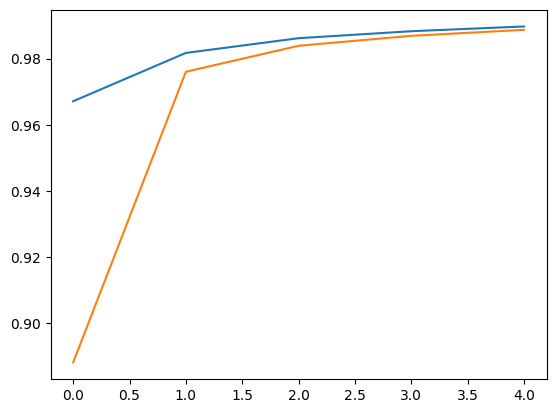

In [ ]:
plt.plot(list_accuracy_test)
plt.plot(list_accuracy_train)
plt.show()

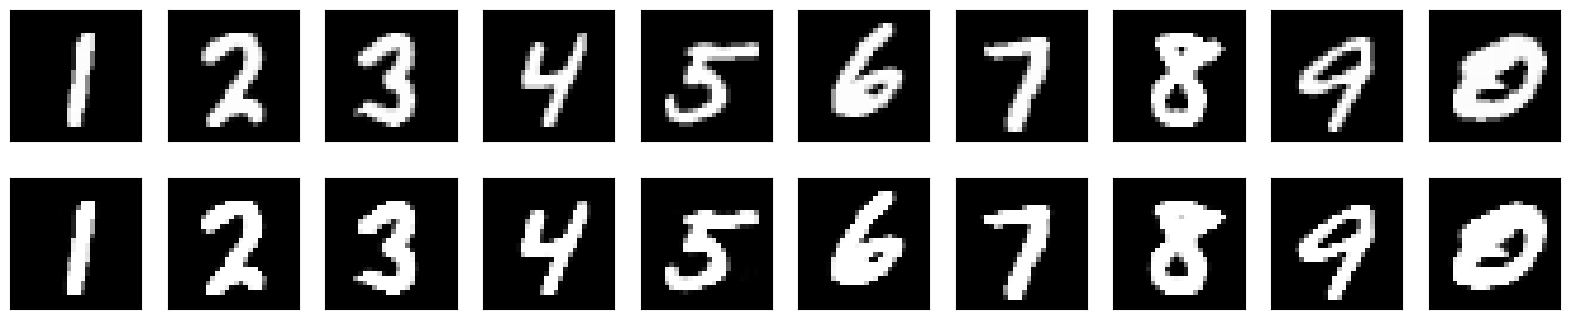

In [ ]:
n = 10

plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(output[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()